In [1]:
import os
#os.environ['SPS_HOME'] = '/home/annalena/sps_fsps'
os.environ['SPS_HOME'] = '/Users/annalena/Documents/GitHub/fsps'

# Fits files

In this notebook we show, how you can store your mock datacube in a fits file, which is the common format in which are observational data handled. We firtss create a mock IFU cube by running the RUBIX pipeline, store it then in a fits file and then lod the data from the fits file.

In [2]:
# NBVAL_SKIP
import matplotlib.pyplot as plt
import os
from rubix.core.pipeline import RubixPipeline

# Define Illustris configuration
config_illustris = {
    "pipeline": {"name": "calc_ifu"},
    "logger": {"log_level": "DEBUG", "log_file_path": None, "format": "%(asctime)s - %(name)s - %(levelname)s - %(message)s"},
    "data": {
        "name": "IllustrisAPI",
        "args": {
            "api_key": os.environ.get("ILLUSTRIS_API_KEY"),
            "particle_type": ["stars", "gas"],
            "simulation": "TNG50-1",
            "snapshot": 99,
            "save_data_path": "data",
        },
        "load_galaxy_args": {"id": 554798, "reuse": True},
        "subset": {"use_subset": True, "subset_size": 1000},
    },
    "simulation": {"name": "IllustrisTNG", "args": {"path": "data/galaxy-id-554798.hdf5"}},
    "output_path": "output",
    "telescope": {"name": "MUSE", "psf": {"name": "gaussian", "size": 5, "sigma": 0.6}, 
                  "lsf": {"sigma": 0.5}, "noise": {"signal_to_noise": 100, "noise_distribution": "normal"}},
    "cosmology": {"name": "PLANCK15"},
    "galaxy": {"dist_z": 0.1, "rotation": {"type": "edge-on"}},
    "ssp": {"template": {"name": "Mastar_CB19_SLOG_1_5"},
            "dust": {
            "extinction_model": "Cardelli89", #"Gordon23", 
            "dust_to_gas_ratio": 0.01, # need to check Remyer's paper
            "dust_to_metals_ratio": 0.4, # do we need this ratio if we set the dust_to_gas_ratio?
            "dust_grain_density": 3.5, # g/cm^3 #check this value
            "Rv": 3.1,
        },
            },
}


# Run pipeline
pipe = RubixPipeline(config_illustris)
data = pipe.run()

2025-03-05 12:44:49,369 - rubix - INFO - 
   ___  __  _____  _____  __
  / _ \/ / / / _ )/  _/ |/_/
 / , _/ /_/ / _  |/ /_>  <
/_/|_|\____/____/___/_/|_|


2025-03-05 12:44:49,369 - rubix - INFO - Rubix version: 0.0.post366+g4480c14
2025-03-05 12:44:49,369 - rubix - INFO - JAX version: 0.5.0
2025-03-05 12:44:49,379 - rubix - INFO - Running on [CpuDevice(id=0)] devices
/Users/annalena/Documents/GitHub/rubix/rubix/telescope/factory.py:24: UserWarning: No telescope config provided, using default stored in /Users/annalena/Documents/GitHub/rubix/rubix/telescope/telescopes.yaml
  warnings.warn(
2025-03-05 12:44:50,526 - rubix - INFO - Getting rubix data...
2025-03-05 12:44:50,527 - rubix - INFO - Loading data from IllustrisAPI
2025-03-05 12:44:50,528 - rubix - INFO - Reusing existing file galaxy-id-554798.hdf5. If you want to download the data again, set reuse=False.
2025-03-05 12:44:50,575 - rubix - INFO - Loading data into input handler
2025-03-05 12:44:50,575 - rubix - DEBUG - Loading dat

Converted to Rubix format!


2025-03-05 12:44:59,701 - rubix - WARNING - The Subset value is set in config. Using only subset of size 1000 for stars
2025-03-05 12:44:59,752 - rubix - INFO - Centering gas particles
2025-03-05 12:45:00,159 - rubix - WARNING - The Subset value is set in config. Using only subset of size 1000 for gas
2025-03-05 12:45:00,167 - rubix - INFO - Data loaded with 1000 star particles and 1000 gas particles.
2025-03-05 12:45:00,168 - rubix - INFO - Setting up the pipeline...
2025-03-05 12:45:00,169 - rubix - DEBUG - Pipeline Configuration: {'Transformers': {'rotate_galaxy': {'name': 'rotate_galaxy', 'depends_on': None, 'args': [], 'kwargs': {}}, 'filter_particles': {'name': 'filter_particles', 'depends_on': 'rotate_galaxy', 'args': [], 'kwargs': {}}, 'spaxel_assignment': {'name': 'spaxel_assignment', 'depends_on': 'filter_particles', 'args': [], 'kwargs': {}}, 'reshape_data': {'name': 'reshape_data', 'depends_on': 'spaxel_assignment', 'args': [], 'kwargs': {}}, 'calculate_spectra': {'name': '

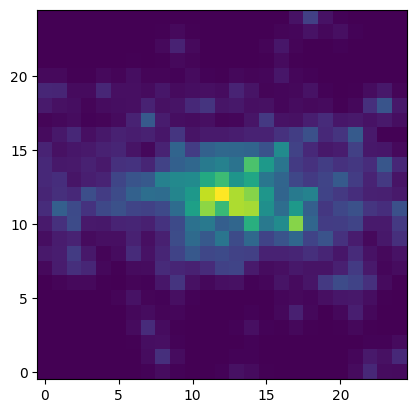

In [3]:
#NBVAL_SKIP
datacube = data.stars.datacube

img = datacube.sum(axis=2)
plt.imshow(img, origin="lower")

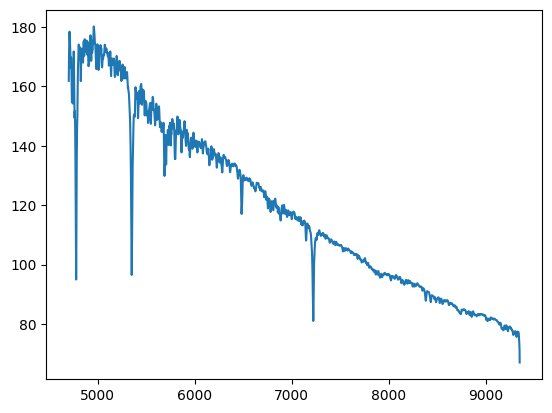

In [4]:
wave = pipe.telescope.wave_seq
plt.plot(wave, data.stars.datacube[12, 12, :], label="Spectrum")

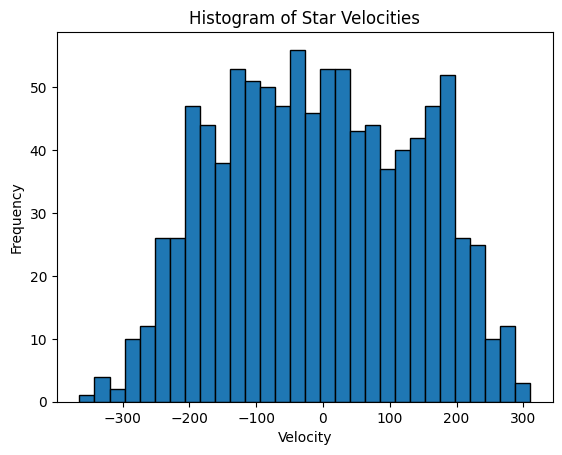

In [5]:
import matplotlib.pyplot as plt

# Plot a histogram of the velocities
plt.hist(data.stars.velocity[0,:,2], bins=30, edgecolor='black')
plt.xlabel('Velocity')
plt.ylabel('Frequency')
plt.title('Histogram of Star Velocities')
plt.show()

/var/folders/jj/bjgx38w95f3f7mrpqbzrxbsh0000gp/T/ipykernel_30273/1578882625.py:13: RuntimeWarning: invalid value encountered in divide
  mean_velocity = sum_velocity / counts


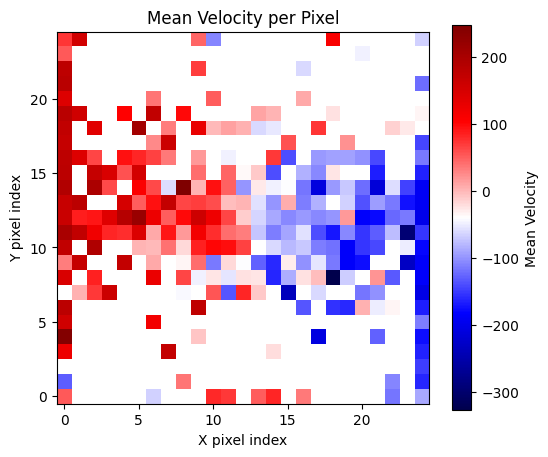

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming your data arrays are defined as follows:
pixel_assignment = np.asarray(np.squeeze(data.stars.pixel_assignment))
velocities = np.asarray(data.stars.velocity[0, :, 2])

# Compute the sum of velocities and count per pixel using np.bincount
sum_velocity = np.bincount(pixel_assignment, weights=velocities)
counts = np.bincount(pixel_assignment)

# Calculate mean velocity; note: division by zero is avoided if every pixel has at least one star.
mean_velocity = sum_velocity / counts

# If you know the pixel grid dimensions (for example, a square grid)
n_pixels = len(mean_velocity)
grid_size = int(np.sqrt(n_pixels))
if grid_size * grid_size != n_pixels:
    raise ValueError("The total number of pixels is not a perfect square; please specify the grid shape explicitly.")

# Reshape the mean_velocity into a 2D array for imshow
velocity_map = mean_velocity.reshape((grid_size, grid_size))

# Plot the result
plt.figure(figsize=(6, 5))
plt.imshow(velocity_map, origin='lower', interpolation='nearest', cmap='seismic')
plt.colorbar(label='Mean Velocity')
plt.title('Mean Velocity per Pixel')
plt.xlabel('X pixel index')
plt.ylabel('Y pixel index')
plt.show()

# Store datacube in a fits file with header

In RUBIX we implemented a function that automaticly takes the relevant information from the config and writes it into the header. Then the header and data are stored in a fits file. All is done with the store_fits function from the rubix.core.fits module.

In [7]:
#NBVAL_SKIP
from rubix.core.fits import store_fits

store_fits(config_illustris, data, "output/")

/Users/annalena/Documents/GitHub/rubix/rubix/telescope/factory.py:24: UserWarning: No telescope config provided, using default stored in /Users/annalena/Documents/GitHub/rubix/rubix/telescope/telescopes.yaml
  warnings.warn(
2025-03-05 12:45:04,227 - rubix - INFO - Datacube saved to output/IllustrisTNG_id554798_snap99_stars_subsetTrue.fits


# Load datacube from fits file

We implemented a function to load a fits file. It is based on MPDAF, which is a package to handle MUSE IFU cubes. You can load your datacube by the following line and access all kind of information from the fitsfile.

In [8]:
#NBVAL_SKIP
from rubix.core.fits import load_fits

cube = load_fits("output/IllustrisTNG_id11_snap99_stars_subsetTrue.fits") #if you use NIHAO, you have to insert the NIHAO fits file

In [9]:
#NBVAL_SKIP
cube.shape

(3721, 25, 25)

In [10]:
#NBVAL_SKIP
cube.info()

[INFO] 3721 x 25 x 25 Cube (output/IllustrisTNG_id11_snap99_stars_subsetTrue.fits)
[INFO] .data(3721 x 25 x 25) (erg / (A s cm2)), no noise
[INFO] center:(00:00:00.2,00:00:00.01333333) size:(5.000",5.000") step:(0.200",0.200") rot:-0.0 deg frame:ICRS
[INFO] wavelength: min:4700.15 max:9350.15 step:1.25 Angstrom


In [11]:
#NBVAL_SKIP
cube.primary_header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
PIPELINE= 'calc_ifu'                                                            
DIST_Z  =                  0.1                                                  
ROTATION= 'edge-on '                                                            
SIM     = 'IllustrisTNG'                                                        
GALAXYID=                   11                                                  
SNAPSHOT=                   99                                                  
SUBSET  =                    T                                                  
SSP     = 'Mastar_CB19_SLOG_1_5'                                                
INSTR   = 'MUSE    '        

<>:7: SyntaxWarning: invalid escape sequence '\l'
<>:7: SyntaxWarning: invalid escape sequence '\l'
/var/folders/jj/bjgx38w95f3f7mrpqbzrxbsh0000gp/T/ipykernel_30273/3772622888.py:7: SyntaxWarning: invalid escape sequence '\l'
  image1.plot(colorbar='v', title = '$\lambda$ = %.1f (%s)' %(cube.wave.coord(1000), cube.wave.unit))


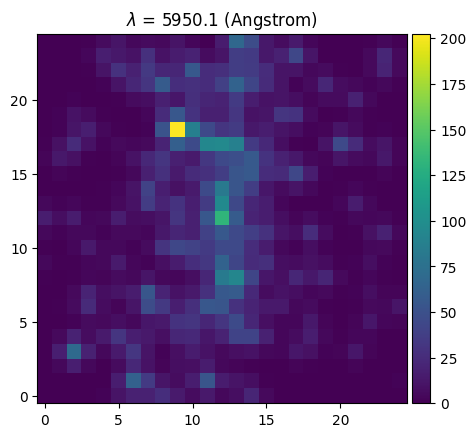

In [12]:
#NBVAL_SKIP
import matplotlib.pyplot as plt

image1 = cube[0,:,:]

plt.figure()
image1.plot(colorbar='v', title = '$\lambda$ = %.1f (%s)' %(cube.wave.coord(1000), cube.wave.unit))
plt.show()